In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
! pip install tensorflow_addons
import tensorflow_addons as tfa
from keras.models import Sequential

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


Pre-process Data

In [9]:
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image
from matplotlib import pyplot as plt
def preprocess_data():
  train = []
  traing = []
  test1=[]
  test1g=[]
  test2=[]
  test2g=[]
  for i in range(1,401):
    imgName=''
    if i<100:
      if i<10:
        imgName='00'+str(i)
      else:
        imgName='0'+str(i)
    else:
      imgName=str(i)
    # maneesh_path = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/train400/test_"
    varun_path = "/content/drive/MyDrive/SMAI/Project/train400/test_"
    file = varun_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)
    t = view_as_windows(image, (50,50), step=30).reshape((-1,50,50)) 
    # print(t.shape) 
    train.append(t)

  varun_path = "/content/drive/MyDrive/SMAI/Project/test12/"
  for i in range(1,8):
    # imgName=''
    # if i<10:
    #   imgName='0'+str(i)
    # else:
    #   imgName=str(i)
    imgName=str(i)
    #maneesh_path = "/content/drive/MyDrive/Colab Notebooks/SMAI /Project/set12/"
    file = varun_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)
    t = view_as_windows(image, (50,50), step=50).reshape((-1,50,50))  
    test1.append(t)

  for i in range(8,13):
    imgName=''
    # if i<10:
    #   imgName='0'+str(i)
    # else:
    #   imgName=str(i)
    imgName=str(i)
    file = varun_path+imgName+".png"
    image = Image.open(file)
    image = np.asarray(image)  
    t = view_as_windows(image, (50,50), step=50).reshape((-1,50,50))
    test2.append(t)

  train =  np.array(train).reshape((-1,50,50))
  test1 =  np.array(test1).reshape((-1,50,50))
  test2 =  np.array(test2).reshape((-1,50,50))

  mean = 0
  sigma = 50

  gauss_noise = np.random.normal(mean,sigma,(50,50))

  traing = train + gauss_noise
  test1g = test1 + gauss_noise
  test2g = test2 + gauss_noise

  train = train/255.0
  traing = traing/255.0
  test1=test1/255.0
  test1g=test1g/255.0
  test2=test2/255.0
  test2g=test2g/255.0

  for i in range(4):
    plt.imshow(train[i],cmap='gray')
    plt.show()
    plt.imshow(traing[i],cmap='gray')
    plt.show()
  for i in range(4):
    plt.imshow(test1[i],cmap='gray')
    plt.show()
    plt.imshow(test1g[i],cmap='gray')
    plt.show()
  
  return train,traing,test1,test1g,test2,test2g

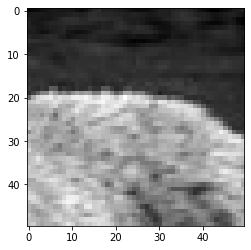

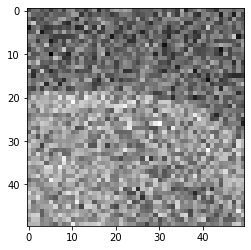

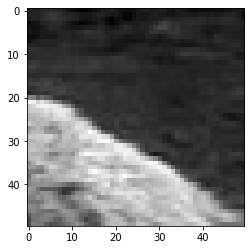

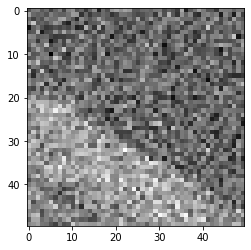

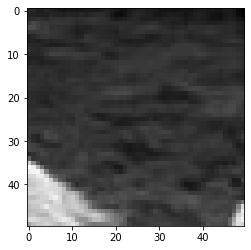

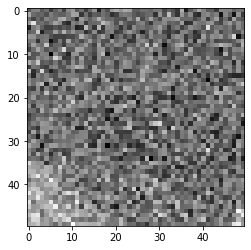

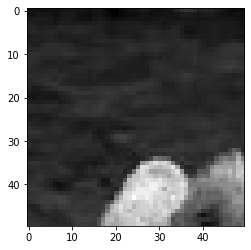

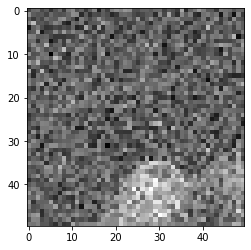

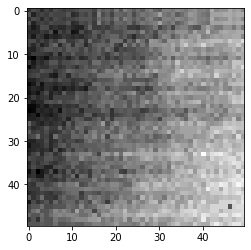

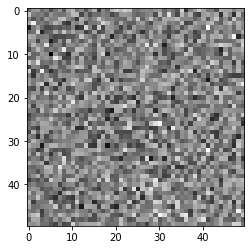

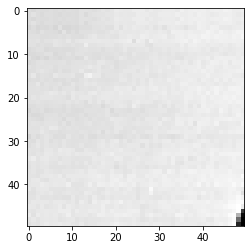

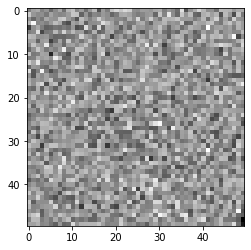

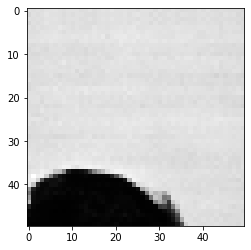

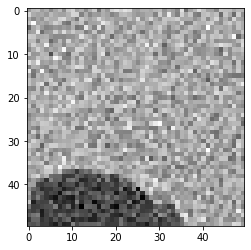

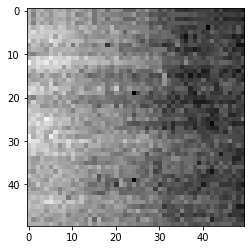

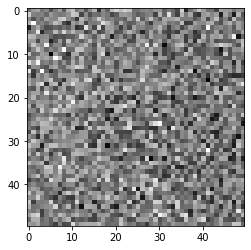

(10000, 50, 50, 1) (10000, 50, 50, 1) (175, 50, 50, 1) (175, 50, 50, 1) (500, 50, 50, 1) (500, 50, 50, 1)


In [10]:
# from sklearn.model_selection import train_test_split

# data, datag = preprocess_data()


# traing, testg, train, test =  train_test_split(datag, data, test_size=0.25, shuffle=True)
train,traing,test1,test1g,test2,test2g=preprocess_data()
train = np.expand_dims(train,axis=-1)
traing = np.expand_dims(traing,axis=-1)
test1 = np.expand_dims(test1,axis=-1)
test1g = np.expand_dims(test1g,axis=-1)
test2 = np.expand_dims(test2,axis=-1)
test2g = np.expand_dims(test2g,axis=-1)
print(train.shape,traing.shape, test1.shape, test1g.shape,test2.shape, test2g.shape)

In [11]:
print(train.shape,traing.shape, test1.shape, test1g.shape,test2.shape, test2g.shape)

(10000, 50, 50, 1) (10000, 50, 50, 1) (175, 50, 50, 1) (175, 50, 50, 1) (500, 50, 50, 1) (500, 50, 50, 1)


###Define Model

In [27]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(input_tensor)
    a=self.conv_block_down(z)

    return tf.keras.layers.Concatenate(axis=-1)([x,y,z,a])

In [28]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(24,(1,1), strides=1,padding="same", activation="relu")
    self.conv_block_up=tf.keras.layers.Conv2D(6,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(6,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_down=tf.keras.layers.Conv2D(6,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(6,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_second=tf.keras.layers.Conv2D(8,(1,1), strides=1,padding="same", activation="relu")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    x=self.conv_block_up(b)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(b)
    a=self.conv_block_down(z)
    add_first=tf.keras.layers.Concatenate(axis=-1)([x,y,z,a])
    f=self.conv_block_second(add_first)
    return tf.keras.layers.Concatenate(axis=-1)([f,input_tensor])

In [29]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

###Build Model

In [16]:
from keras.models import Sequential
def DBF(N, train_x,train_y):
  model = Sequential()

  model.add(FeatureExtraction())
  for i in range(N):
    model.add(FeatureIntegration())
  model.add(Reconstruction())

  # opt=tf.keras.optimizers.Adam(
  #     learning_rate=0.001,
  #     name='Adam',
  # )
  opt= tfa.optimizers.AdamW(
      weight_decay=0.0001, # 
      learning_rate= 0.001,
      name= 'AdamW',
  )
  model.compile(loss='mse',optimizer=opt)
  return model

model_DBF_3=DBF(3,traing,train)
results = model_DBF_3.fit(traing, train, epochs=25, verbose=1,batch_size=64)
model_DBF_3.summary()



Epoch 1/25
157/157 [==============================] - 20s 114ms/step - loss: 0.0125
Epoch 2/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0048
Epoch 3/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0044
Epoch 4/25
157/157 [==============================] - 18s 114ms/step - loss: 0.0040
Epoch 5/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0038
Epoch 6/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0035
Epoch 7/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0034
Epoch 8/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0032
Epoch 9/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0031
Epoch 10/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0030
Epoch 11/25
157/157 [==============================] - 18s 113ms/step - loss: 0.0030
Epoch 12/25
157/157 [==============================] - 18s 114ms/step - lo

In [ ]:
import pickle
# with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_500.pickle', 'wb') as f:
#     pickle.dump(model, f)

# with open('/content/drive/MyDrive/Colab Notebooks/SMAI /Project/model_500.pickle', 'rb') as f:
#     model = pickle.load(f)

INFO:tensorflow:Assets written to: ram://9df2cf48-8f21-4c02-b814-b4a402a8c126/assets


In [ ]:
import numpy as np
from math import log2, log10

def _initial_check(GT,P):
	assert GT.shape == P.shape, "Supplied images have different sizes " + \
	str(GT.shape) + " and " + str(P.shape)
	if GT.dtype != P.dtype:
		msg = "Supplied images have different dtypes " + \
			str(GT.dtype) + " and " + str(P.dtype)
		print(msg)
	

	if len(GT.shape) == 2:
		GT = GT[:,:,np.newaxis]
		P = P[:,:,np.newaxis]

	return GT.astype(np.float64),P.astype(np.float64)

def mse (GT,P):
	"""calculates mean squared error (mse).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.

	:returns:  float -- mse value.
	"""
	GT,P = _initial_check(GT,P)
	return np.mean((GT.astype(np.float64)-P.astype(np.float64))**2)

def psnr (GT,P,MAX=None):
	"""calculates peak signal-to-noise ratio (psnr).

	:param GT: first (original) input image.
	:param P: second (deformed) input image.
	:param MAX: maximum value of datarange (if None, MAX is calculated using image dtype).

	:returns:  float -- psnr value in dB.
	"""
	if MAX is None:
		MAX = np.iinfo(GT.dtype).max

	GT,P = _initial_check(GT,P)

	mse_value = mse(GT,P)
	if mse_value == 0.:
		return np.inf
	return 10 * np.log10(MAX**2 /mse_value)

In [17]:
pred1 = model_DBF_3(test1g)
pred2 = model_DBF_3(test2g)
# print(pred.shape,test.shape)

mseloss1 = ((test1.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred1-test1)**2)+((test2.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred2-test2)**2)
# mseloss1 = (7/12)*np.mean((pred1-test1)**2)+(5/12)*np.mean((pred2-test2)**2)
# mseloss2 = (1/2)*np.mean((pred1-test1)**2)+(1/2)*np.mean((pred2-test2)**2)

# mseloss = np.mean((pred.astype(np.float64)-P.astype(np.float64))**2)
psnr_1 =   10*np.log10(1/mseloss1)
# psnr_2 =   10*np.log10(1/mseloss2)
print("psnr with model",psnr_1)
# print("psnr with model",psnr_2)

psnr with model 27.813413232488085


In [30]:
model_DBF_5=DBF(5,traing,train)
results = model_DBF_5.fit(traing, train, epochs=25, verbose=1,batch_size=64)
model_DBF_5.summary()

pred1 = model_DBF_5(test1g)
pred2 = model_DBF_5(test2g)

mseloss1 = ((test1.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred1-test1)**2)+((test2.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred2-test2)**2)
psnr_1 =   10*np.log10(1/mseloss1)
print("psnr with model",psnr_1)


Epoch 1/25
157/157 [==============================] - 32s 177ms/step - loss: 0.0108
Epoch 2/25
157/157 [==============================] - 28s 181ms/step - loss: 0.0046
Epoch 3/25
157/157 [==============================] - 28s 177ms/step - loss: 0.0040
Epoch 4/25
157/157 [==============================] - 28s 177ms/step - loss: 0.0035
Epoch 5/25
157/157 [==============================] - 28s 177ms/step - loss: 0.0033
Epoch 6/25
157/157 [==============================] - 28s 177ms/step - loss: 0.0031
Epoch 7/25
157/157 [==============================] - 28s 176ms/step - loss: 0.0029
Epoch 8/25
157/157 [==============================] - 28s 176ms/step - loss: 0.0027
Epoch 9/25
157/157 [==============================] - 28s 176ms/step - loss: 0.0026
Epoch 10/25
157/157 [==============================] - 28s 176ms/step - loss: 0.0025
Epoch 11/25
157/157 [==============================] - 28s 176ms/step - loss: 0.0024
Epoch 12/25
157/157 [==============================] - 28s 176ms/step - lo

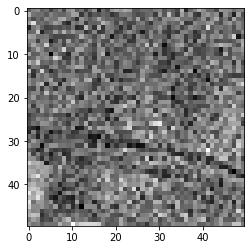

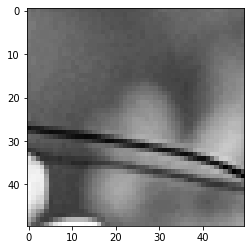

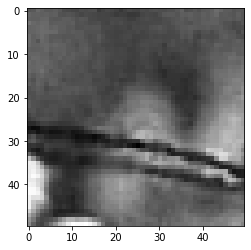

In [18]:
ind=100

plt.imshow(np.squeeze(test1g[ind],(-1)),cmap='gray')
plt.show()

plt.imshow(np.squeeze(test1[ind],(-1)),cmap='gray')
plt.show()

temp = np.expand_dims(test1g[ind],axis=0)

pred = model_DBF_3(temp)

pred = np.squeeze(pred,(0,-1))

plt.imshow(pred*256,cmap='gray')
plt.show()

###DBF without wide (N layers)

In [31]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(16,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(16,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    return tf.keras.layers.Concatenate(axis=-1)([x,y])

In [32]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(32,(1,1), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    y=self.dilated_conv_block_up(b)
    return tf.keras.layers.Concatenate(axis=-1)([input_tensor,y])

In [33]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

In [23]:
def get_DBF_non_wide(N,train_x,train_y):
  model = Sequential()

  model.add(FeatureExtraction())

  for i in range(N):
   model.add(FeatureIntegration())
  # model.add(FeatureIntegration())
  # model.add(FeatureIntegration())

  model.add(Reconstruction())

  # opt = tfa.optimizers.SGDW(
  #     weight_decay = 0.0001,
  #     learning_rate =  0.001,
  #     momentum = 0.9,
  # )
  
  opt= tfa.optimizers.AdamW(
    weight_decay=0.0001,
    learning_rate= 0.001,
    name= 'AdamW')
  model.compile(loss='mse',optimizer=opt)
  results = model.fit(train_x,train_y, epochs=25, verbose=1,batch_size=64)
  model.summary()
  return model

In [24]:
traing.shape,train.shape

((10000, 50, 50, 1), (10000, 50, 50, 1))

In [ ]:
model8=get_DBF_non_wide(8,traing,train)
# model5=get_DBF_non_wide(5)
# model8=get_DBF_non_wide(8)
pred1 = model8(test1g)
pred2 = model8(test2g)
# print(pred.shape,test.shape)

In [34]:
model5=get_DBF_non_wide(5,traing,train)
pred1 = model5(test1g)
pred2 = model5(test2g)

mseloss1 = ((test1.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred1-test1)**2)+((test2.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred2-test2)**2)
# mseloss2 = (1/2)*np.mean((pred1-test1)**2)+(1/2)*np.mean((pred2-test2)**2)

# mseloss = np.mean((pred.astype(np.float64)-P.astype(np.float64))**2)
psnr_1 =   10*np.log10(1/mseloss1)
# psnr_2 =   10*np.log10(1/mseloss2)
print("psnr with model",psnr_1)
# print("psnr with model",psnr_2)

Epoch 1/25
157/157 [==============================] - 18s 106ms/step - loss: 0.0109
Epoch 2/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0048
Epoch 3/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0043
Epoch 4/25
157/157 [==============================] - 17s 106ms/step - loss: 0.0041
Epoch 5/25
157/157 [==============================] - 17s 106ms/step - loss: 0.0038
Epoch 6/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0036
Epoch 7/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0035
Epoch 8/25
157/157 [==============================] - 17s 106ms/step - loss: 0.0034
Epoch 9/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0032
Epoch 10/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0031
Epoch 11/25
157/157 [==============================] - 17s 105ms/step - loss: 0.0031
Epoch 12/25
157/157 [==============================] - 17s 105ms/step - lo

In [25]:

model3=get_DBF_non_wide(3,traing,train)
# model5=get_DBF_non_wide(5)
# model8=get_DBF_non_wide(8)
pred1 = model3(test1g)
pred2 = model3(test2g)
# print(pred.shape,test.shape)

Epoch 1/25
157/157 [==============================] - 13s 71ms/step - loss: 0.0123
Epoch 2/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0051
Epoch 3/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0048
Epoch 4/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0047
Epoch 5/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0045
Epoch 6/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0041
Epoch 7/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0038
Epoch 8/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0036
Epoch 9/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0035
Epoch 10/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0034
Epoch 11/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0033
Epoch 12/25
157/157 [==============================] - 11s 70ms/step - loss: 0.0033
E

In [26]:
mseloss1 = ((test1.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred1-test1)**2)+((test2.shape[0])/(test1.shape[0]+test2.shape[0]))*np.mean((pred2-test2)**2)
# mseloss2 = (1/2)*np.mean((pred1-test1)**2)+(1/2)*np.mean((pred2-test2)**2)

# mseloss = np.mean((pred.astype(np.float64)-P.astype(np.float64))**2)
psnr_1 =   10*np.log10(1/mseloss1)
# psnr_2 =   10*np.log10(1/mseloss2)
print("psnr with model",psnr_1)
# print("psnr with model",psnr_2)

psnr with model 26.79392303178996
